In [26]:
from keras.layers import Dense, Input, Lambda
from keras.models import Model
from keras.datasets import mnist
from keras.losses import mse
from keras import backend as K

import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import argparse
import os
%matplotlib inline

In [27]:
# Load and reshape MNIST data 
(X_train, y_train), (X_test, y_test) = mnist.load_data()
X_train, X_test = X_train / 255., X_test / 255.
X_train, X_test = X_train.reshape([-1, 784]), X_test.reshape([-1, 784])
X_train = X_train.astype(np.float32, copy=False)
X_test = X_test.astype(np.float32, copy=False)

In [28]:
X_dim = 784 # input dimension
batch_size = 64 # mini-batch size
epochs = 30 
hidden_dim = 256 # hidden layer dimension
z_dim = 2 # latent dimension

In [45]:
# Plot latent space in 2D
def plot_digits(X, y, encoder, batch_size=128):
    z_mu, _, _ = encoder.predict(X, batch_size=batch_size)
    fig = plt.figure(figsize=(12, 10))
    plt.scatter(z_mu[:, 0], z_mu[:, 1], c=y)
    plt.colorbar()
    plt.xlabel("z[0]")
    plt.ylabel("z[1]")
    plt.show()
    
    return fig
    

# Generate mnist manifold
def generate_manifold(decoder):  
    n = 30
    digit_size = 28
    figure = np.zeros((digit_size * n, digit_size * n))
    grid_x = np.linspace(-4, 4, n)
    grid_y = np.linspace(-4, 4, n)[::-1]   
    for i, yi in enumerate(grid_y):
        for j, xi in enumerate(grid_x):
            z_sample = np.array([[xi, yi]])
            x_decoded = decoder.predict(z_sample)
            digit = x_decoded[0].reshape(digit_size, digit_size)
            figure[i * digit_size: (i + 1) * digit_size,
                   j * digit_size: (j + 1) * digit_size] = digit           
    fig = plt.figure(figsize=(10, 10))
    start_range = digit_size // 2
    end_range = n * digit_size + start_range + 1
    pixel_range = np.arange(start_range, end_range, digit_size)
    sample_range_x = np.round(grid_x, 1)
    sample_range_y = np.round(grid_y, 1)  
    plt.xticks(pixel_range, sample_range_x)
    plt.yticks(pixel_range, sample_range_y)
    plt.xlabel("z[0]")
    plt.ylabel("z[1]")
    plt.imshow(figure, cmap='Greys_r')
    plt.show()
    
    return fig
      
# Plot images
def reconstruction(X_test):
    w = h = int(np.sqrt(X_dim))
    X_hat = vae.predict(X_test)
    n = np.sqrt(100).astype(np.int32)
    I_reconstructed = np.empty((h*n, 2*w*n))
    for i in range(n):
        for j in range(n):
            x = np.concatenate(
                (X_hat[i*n+j, :].reshape(h, w), 
                 X_test[i*n+j, :].reshape(h, w)),
                axis=1
            )
            I_reconstructed[i*h:(i+1)*h, j*2*w:(j+1)*2*w] = x

    fig = plt.figure(figsize=(20, 40))
    plt.imshow(I_reconstructed, cmap='gray')
    
    return fig


if not os.path.exists('results/'):
    os.makedirs('results/')

In [30]:
# Reparameterization trick
def sampling(args):
    z_mu, z_log_var = args
    eps = tf.random_normal(K.shape(z_log_var), dtype=np.float32, mean=0., stddev=1.0, name='epsilon')
    z = z_mu + K.exp(z_log_var / 2) * eps
    return z

In [31]:
# Encoder network
inputs = Input(shape=(X_dim, ), name='input')
x = Dense(hidden_dim, activation='relu')(inputs)
z_mu = Dense(z_dim, name='z_mu')(x)
z_log_var = Dense(z_dim, name='z_log_var')(x)
z = Lambda(sampling, name='z')([z_mu, z_log_var])
# Instantiate encoder model
encoder = Model(inputs, [z_mu, z_log_var, z], name='vae_encoder')
encoder.summary()

Model: "vae_encoder"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input (InputLayer)              (None, 784)          0                                            
__________________________________________________________________________________________________
dense_4 (Dense)                 (None, 256)          200960      input[0][0]                      
__________________________________________________________________________________________________
z_mu (Dense)                    (None, 2)            514         dense_4[0][0]                    
__________________________________________________________________________________________________
z_log_var (Dense)               (None, 2)            514         dense_4[0][0]                    
________________________________________________________________________________________

In [32]:
# Decoder network
z_inputs = Input(shape=(z_dim,), name='z_sampling')
x = Dense(hidden_dim, activation='relu')(z_inputs)
outputs = Dense(X_dim, activation='sigmoid')(x)
# Instantiate decoder model
decoder = Model(z_inputs, outputs, name='vae_decoder')
decoder.summary()

Model: "vae_decoder"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
z_sampling (InputLayer)      (None, 2)                 0         
_________________________________________________________________
dense_5 (Dense)              (None, 256)               768       
_________________________________________________________________
dense_6 (Dense)              (None, 784)               201488    
Total params: 202,256
Trainable params: 202,256
Non-trainable params: 0
_________________________________________________________________


In [33]:
# VAE model
outputs = decoder(encoder(inputs)[2]) 
vae = Model(inputs, outputs, name='vanilla_vae')

In [34]:
# Loss function
# Reconstruction loss
reconstruction_loss = mse(inputs, outputs)
reconstruction_loss = reconstruction_loss * X_dim
# KL Divergence
kl_loss = 1 + z_log_var - K.square(z_mu) - K.exp(z_log_var)
kl_loss = -0.5 * tf.reduce_sum(kl_loss, axis=-1)
vae_loss = tf.reduce_mean(reconstruction_loss + kl_loss)
vae.add_loss(vae_loss)
vae.compile(optimizer='adam')
vae.summary()

Model: "vanilla_vae"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input (InputLayer)           (None, 784)               0         
_________________________________________________________________
vae_encoder (Model)          [(None, 2), (None, 2), (N 201988    
_________________________________________________________________
vae_decoder (Model)          (None, 784)               202256    
Total params: 404,244
Trainable params: 404,244
Non-trainable params: 0
_________________________________________________________________


In [35]:
# Training session
history = vae.fit(X_train, epochs=epochs, batch_size=batch_size, validation_data=(X_test, None))

Train on 60000 samples, validate on 10000 samples
Epoch 1/30
60000/60000 [==============================] - 6s 108us/step - loss: 50.5715 - val_loss: 44.0093
Epoch 2/30
60000/60000 [==============================] - 6s 99us/step - loss: 43.5785 - val_loss: 42.6907
Epoch 3/30
60000/60000 [==============================] - 6s 105us/step - loss: 42.4873 - val_loss: 41.8477
Epoch 4/30
60000/60000 [==============================] - 6s 105us/step - loss: 41.7469 - val_loss: 41.3325
Epoch 5/30
60000/60000 [==============================] - 6s 106us/step - loss: 41.1753 - val_loss: 40.7234
Epoch 6/30
60000/60000 [==============================] - 6s 105us/step - loss: 40.7854 - val_loss: 40.4186
Epoch 7/30
60000/60000 [==============================] - 6s 105us/step - loss: 40.4620 - val_loss: 40.2409
Epoch 8/30
60000/60000 [==============================] - 6s 105us/step - loss: 40.1992 - val_loss: 40.0713
Epoch 9/30
60000/60000 [==============================] - 6s 107us/step - loss: 39.9870

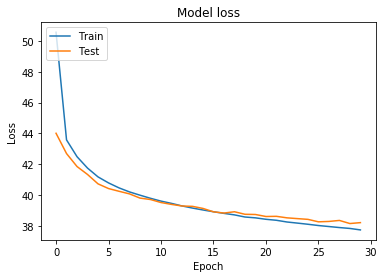

In [36]:
# Plot training & validation loss values
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

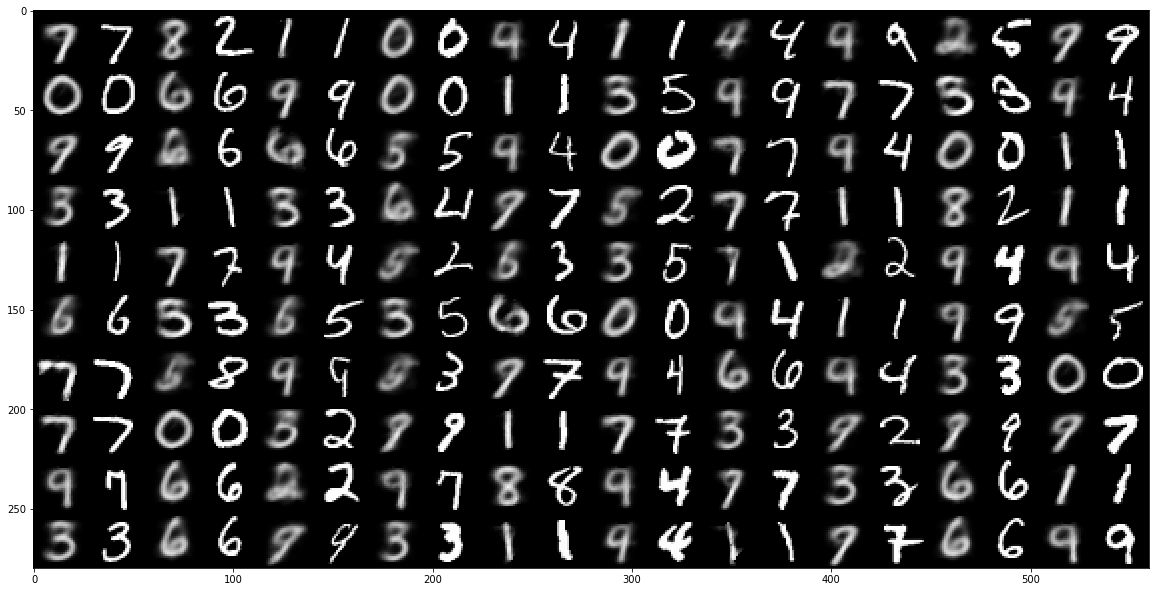

In [46]:
# Reconstruction of images
fig = reconstruction(X_test[:100])
plt.savefig('results/reconstruction_images.png')

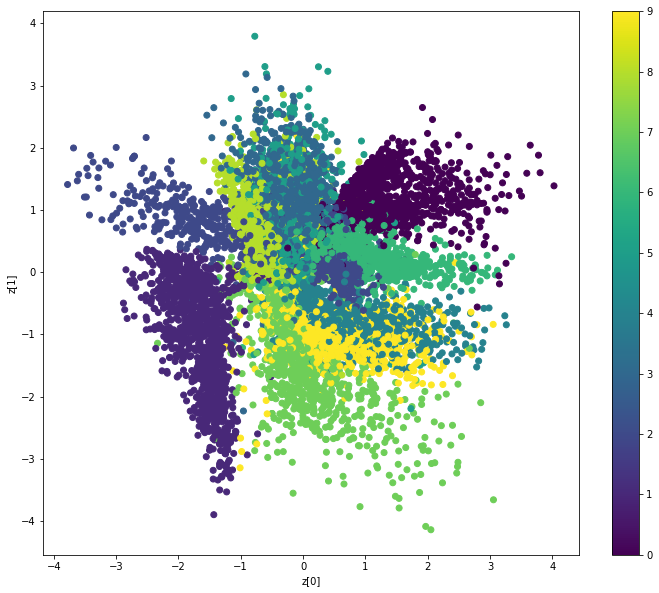

In [37]:
# Plot latent space in 2D    
fig = plot_digits(X_test, y_test, encoder)
plt.savefig('results/latent_space_representation.png')

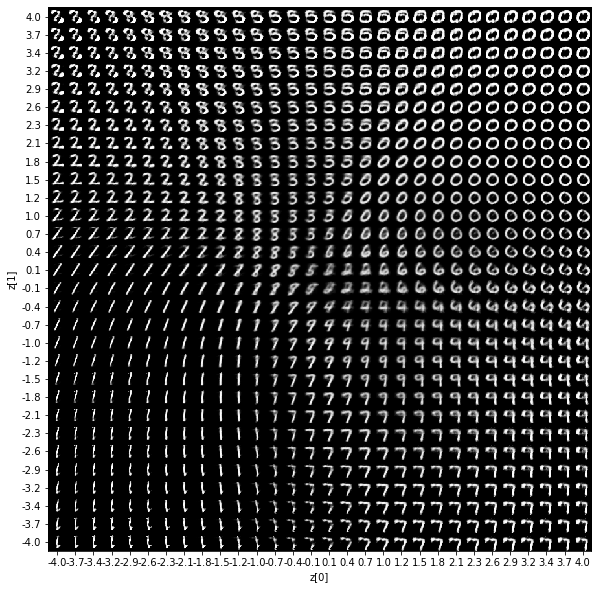

In [38]:
# Generate MNIST manifold
fig = generate_manifold(decoder)
plt.savefig('results/mnist_manifold.png')

In [39]:
# Calculate FID Score
X_hat = vae.predict(X_test)

from numpy import cov
from numpy import trace
from numpy import iscomplexobj
from numpy.random import random
from scipy.linalg import sqrtm

def fid_score(X_test, X_hat):
    m = X_test.shape[0]
    X = X_test.reshape((m, X_dim))
    Y = X_hat.reshape((m, X_dim))
    mu1, sigma1 = X.mean(axis=0), cov(X, rowvar=False)
    mu2, sigma2 = Y.mean(axis=0), cov(Y, rowvar=False)
    sum_square_diff = np.sum((mu1 - mu2)**2.0)
    covmean = sqrtm(sigma1.dot(sigma2))
    if iscomplexobj(covmean):
        covmean = covmean.real
    fid = sum_square_diff + trace(sigma1 + sigma2 - 2.0 * covmean)
    return fid

fid = fid_score(X_test, X_hat)
print('FID Score = ', fid)



FID Score =  20.359034291826934
